In [ ]:
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
# Menghubungkan Google Colab dengan Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Menentukan Direktori
base_dir = '/content/drive/My Drive/Dataset-original-proses/'

# Menampilkan Isi Direktori
!ls "/content/drive/My Drive/Dataset-original-proses"

Mounted at /content/drive
LAKI-LAKI  PEREMPUAN


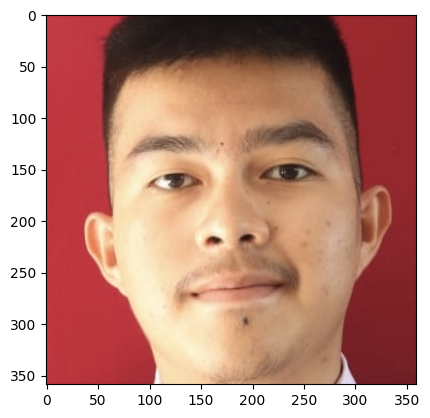

In [ ]:
# Menampilkan salah satu gambar dari Folder 'LAKI-LAKI'

img_path = os.path.join(base_dir, 'LAKI-LAKI', '11S23004_Rudi Alva Jonathan Ginting.jpg')
imgL = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.show()

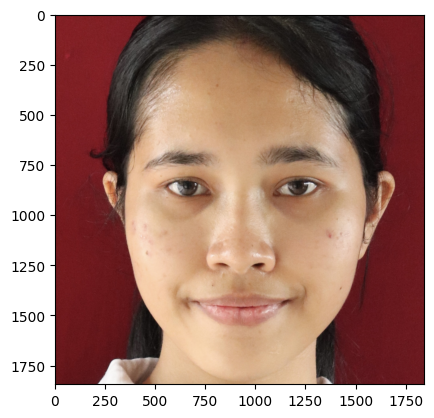

In [ ]:
# Menampilkan salah satu gambar dari Folder 'PEREMPUAN'

img_path = os.path.join(base_dir, 'PEREMPUAN', '11S23006_Sri Intan Ivana Pasaribu.jpg')
imgL = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(base_dir)

Found 400 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
def load_images(image_directory):
    images = []
    for filename in os.listdir(image_directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Handles various image formats
            try:
                img = Image.open(os.path.join(image_directory, filename))
                img.verify()  # Verifies that it's a valid image
                images.append(img)
            except (IOError, SyntaxError) as e:
                print('Bad file:', filename)  # Print out the names of corrupt files
    return images

In [ ]:
batch = next(data_iterator)

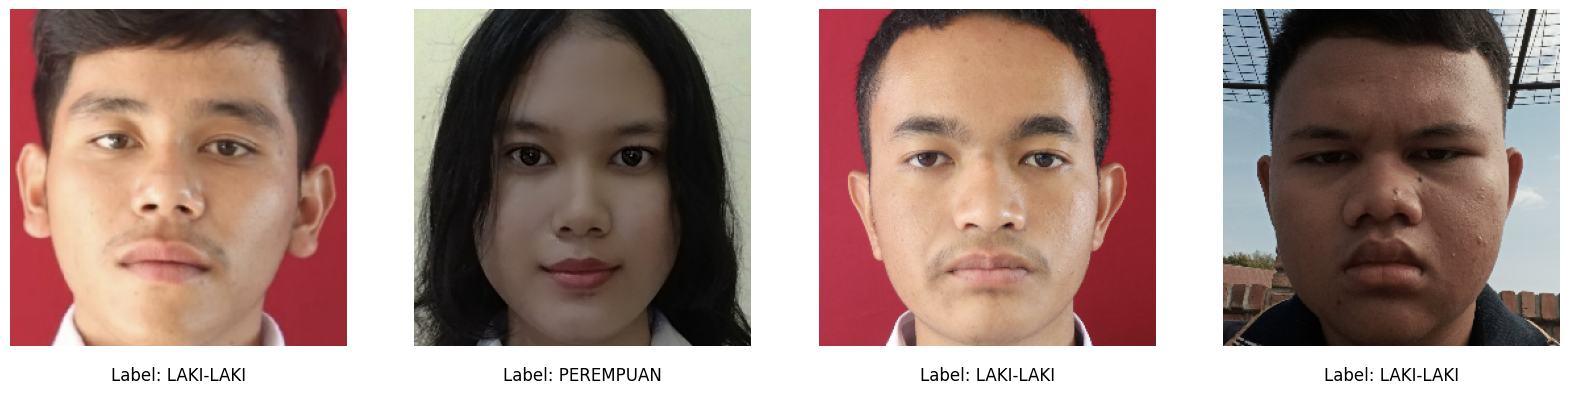

In [ ]:
class_names = data.class_names  # Ambil nama kelas dari dataset

# Menampilkan beberapa gambar dari batch
fig, axes = plt.subplots(ncols=4, figsize=(20, 20))
for idx, ax in enumerate(axes.flat):
    image = batch[0][idx].astype(np.uint8)  # Pastikan tipe data yang benar untuk ditampilkan
    label_numeric = batch[1][idx]  # Label numerik

    ax.imshow(image)
    ax.axis('off')
    ax.text(0.5, -0.1, f'Label: {class_names[label_numeric]}', color='black', fontsize=12, ha='center', transform=ax.transAxes)

plt.show()

**PREPROCESSING KONTRAS (JANGAN DI RUN)**

In [ ]:
import cv2
import numpy as np
import os
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt

# Function to calculate contrast
def calculate_contrast(image):
    return np.std(image)

In [ ]:
# Function to gather statistics from the images in the directory
def gather_statistics(directory):
    contrasts = []

    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(root, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                if image is None:
                    continue

                contrasts.append(calculate_contrast(image))

    return contrasts


In [ ]:
# Path to your image directory
image_directory = '/content/drive/My Drive/Dataset-original-proses'
contrasts = gather_statistics(image_directory)


In [ ]:
# Calculating descriptive statistics for contrast
contrast_mean = np.mean(contrasts)
contrast_median = np.median(contrasts)
contrast_std = np.std(contrasts)

print(f"Contrast - Mean: {contrast_mean}, Median: {contrast_median}, Std: {contrast_std}")

Contrast - Mean: 51.820018032025516, Median: 53.00326048519369, Std: 10.798548892825975


In [ ]:
# Function to determine if an image needs CLAHE
def needs_clahe(image, contrast_threshold):
    contrast = calculate_contrast(image)
    return contrast < contrast_threshold

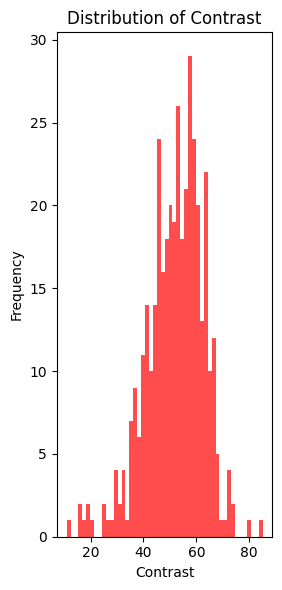

In [ ]:
# Plot histogram for the distribution of variance, entropy, and contrast
plt.figure(figsize=(8, 6))


plt.subplot(1, 3, 3)
plt.hist(contrasts, bins=50, color='red', alpha=0.7)
plt.title('Distribution of Contrast')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Directory to save processed images
processed_images_dir = '/content/drive/My Drive/Dataset-original-processing'

In [ ]:
# Function to display original and processed images with statistics
def display_images(original, processed, original_std, processed_std, title='Processed Image'):
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    # Original image
    axs[0, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    # Processed image
    axs[0, 1].imshow(processed, cmap='gray')
    axs[0, 1].set_title(title)
    axs[0, 1].axis('off')

    # Original image stats
    axs[1, 0].text(0.5, 0.5, f"Standard Deviation: {original_std:.2f}",
                   horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[1, 0].set_title('Original Image Stats')
    axs[1, 0].axis('off')

    # Processed image stats
    axs[1, 1].text(0.5, 0.5, f"Standard Deviation: {processed_std:.2f}",
                   horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[1, 1].set_title('Processed Image Stats')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import shutil

def process_directory(directory, contrast_threshold):
    if not os.path.exists(processed_images_dir):
        os.makedirs(processed_images_dir)
        print(f"Created directory: {processed_images_dir}")

    print(f"Processing directory: {directory}")
    sample_contrast = False

    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(root, filename)
                image = cv2.imread(image_path)

                if image is None:
                    print(f"Failed to load image: {filename}")
                    continue

                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                original_std = calculate_contrast(gray_image)
                needs_contrast = needs_clahe(gray_image, contrast_threshold)

                if needs_contrast:
                    processed_image = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray_image)
                    title = 'Processed Image (CLAHE)'
                    print(f"Image {filename} needs CLAHE.")
                    if not sample_contrast:
                        processed_std = calculate_contrast(processed_image)
                        display_images(image, processed_image, original_std, processed_std, title=title)
                        sample_contrast = True
# Buat subdirektori terkait di direktori baru
                    relative_path = os.path.relpath(root, directory)
                    new_subdir = os.path.join(processed_images_dir, relative_path)
                    if not os.path.exists(new_subdir):
                        os.makedirs(new_subdir)

                    save_path = os.path.join(new_subdir, filename)
                    cv2.imwrite(save_path, processed_image)
                    print(f"Image {filename} processed and saved to {save_path}")

                    # Menghapus gambar originalk
                    os.remove(image_path)
                    print(f"Image {filename} removed from original directory.")
                else:
                    # Menyalin gambar
                    relative_path = os.path.relpath(root, directory)
                    new_subdir = os.path.join(processed_images_dir, relative_path)
                    if not os.path.exists(new_subdir):
                        os.makedirs(new_subdir)
                    save_path = os.path.join(new_subdir, filename)
                    shutil.copyfile(image_path, save_path)
                    print(f"Image {filename} does not need processing and is copied to {save_path}")
            else:
                print(f"Skipped file: {filename}")

Created directory: /content/drive/My Drive/Dataset-original-processing
Processing directory: /content/drive/My Drive/Dataset-original-proses
Image 11S23015_Ayu Hutasoit_Pencahayaan Kurang.jpg does not need processing and is copied to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/11S23015_Ayu Hutasoit_Pencahayaan Kurang.jpg
Image 12S23050_Yolanda Septania Saragih_Pencahayaan Kurang.jpg does not need processing and is copied to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/12S23050_Yolanda Septania Saragih_Pencahayaan Kurang.jpg
Image 11323007_Romian A. Tambunan_Pencahayaan Normal.jpg does not need processing and is copied to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/11323007_Romian A. Tambunan_Pencahayaan Normal.jpg
Image 11S23045_Lofelyn Enzely Ambarita_Pencahayaan Normal.jpg does not need processing and is copied to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/11S23045_Lofelyn Enzely Ambarita_Pencahayaan Normal.jpg
I

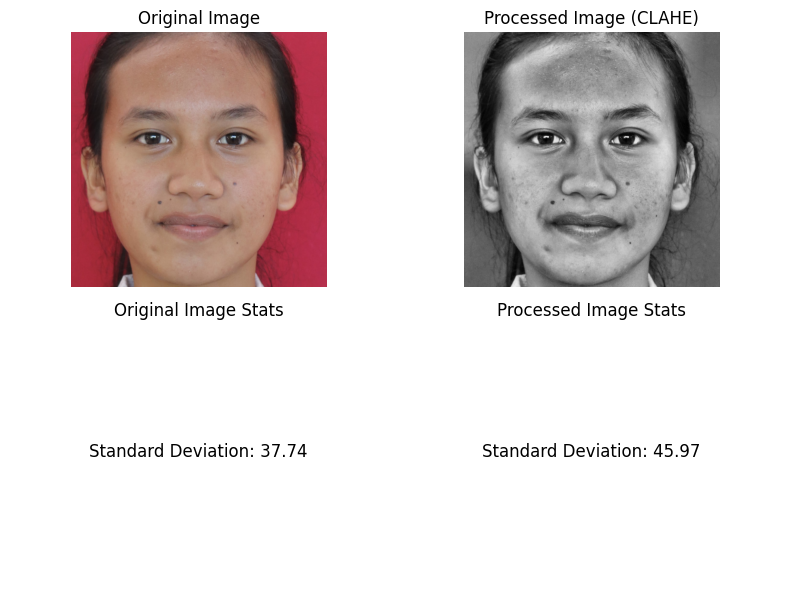

Image 11423012_Esticka Priscila Sibarani.jpg processed and saved to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/11423012_Esticka Priscila Sibarani.jpg
Image 11423012_Esticka Priscila Sibarani.jpg removed from original directory.
Image 31S23003_Elia Yudika Harianja.jpg does not need processing and is copied to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/31S23003_Elia Yudika Harianja.jpg
Image 11S23016_Rahel Pasaribu.jpg does not need processing and is copied to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/11S23016_Rahel Pasaribu.jpg
Image 11S23043_Grace Evelin Siallagan.jpg does not need processing and is copied to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/11S23043_Grace Evelin Siallagan.jpg
Image 11S23044_Maharani Sitorus_Pencahayaan Kurang.jpg does not need processing and is copied to /content/drive/My Drive/Dataset-original-processing/PEREMPUAN/11S23044_Maharani Sitorus_Pencahayaan Kurang.jpg
Image 11S23047_Helg

In [ ]:
# Thresholds for determining CLAHE need based on statistical analysis
contrast_threshold = contrast_mean - contrast_std

# Check if directory exists and process images
if not os.path.isdir(image_directory):
    print(f"Directory {image_directory} does not exist.")
else:
    process_directory(image_directory, contrast_threshold)


**PEMILIHAN PROPORSI DATA**

Checking folder: /content/drive/My Drive/Dataset-original-processing/LAKI-LAKI
Checking folder: /content/drive/My Drive/Dataset-original-processing/PEREMPUAN
Total images loaded: 400
Found 240 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Epoch 1/5
8/8 [==============================] - 40s 5s/step - loss: 0.6163 - accuracy: 0.6708 - val_loss: 0.3299 - val_accuracy: 0.8875
Epoch 2/5
8/8 [==============================] - 20s 3s/step - loss: 0.2940 - accuracy: 0.8792 - val_loss: 0.2207 - val_accuracy: 0.9062
Epoch 3/5
8/8 [==============================] - 15s 2s/step - loss: 0.1818 - accuracy: 0.9208 - val_loss: 0.2220 - val_accuracy: 0.9062
Epoch 4/5
8/8 [==============================] - 20s 2s/step - loss: 0.1339 - accuracy: 0.9500 - val_loss: 0.1819 - val_accuracy: 0.9250
Epoch 5/5
8/8 [==============================] - 16s 2s/step - loss: 0.0662 - accuracy: 0.9917 - val_loss: 0.1899 - val_accuracy: 0.9375
Found 279 va

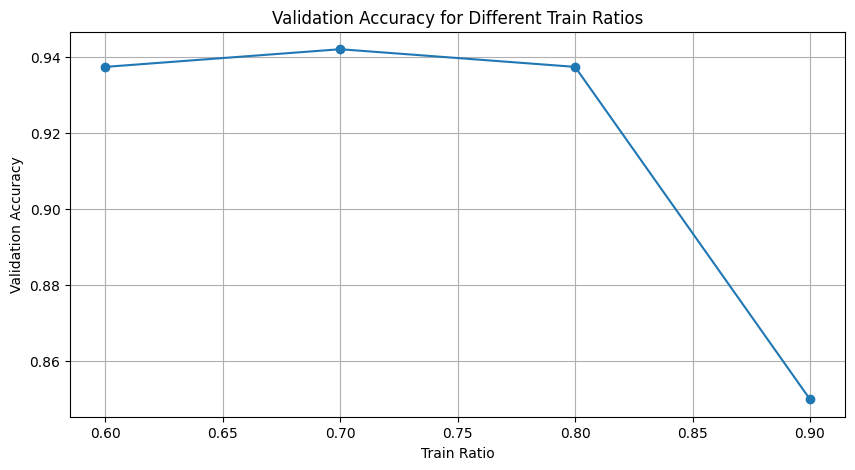

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

# Load MobileNetV3 from TensorFlow Hub
mobilenet_v3_large_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
mobilenet_v3_layer = hub.KerasLayer(mobilenet_v3_large_url, input_shape=(224, 224, 3), trainable=False)

# Function to load image paths and labels
def load_images_from_folders(main_dir, subdirs):
    images = []
    labels = []
    for subdir in subdirs:
        folder = os.path.join(main_dir, subdir)
        print(f"Checking folder: {folder}")  # Debug: Print the folder being checked
        if os.path.isdir(folder):
            for filename in os.listdir(folder):
                if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(folder, filename)
                    images.append(img_path)
                    labels.append(subdir)
    print(f"Total images loaded: {len(images)}")  # Debug: Print the total number of images loaded
    return np.array(images), np.array(labels)

# Function to create and compile the model
def create_model():
    model = Sequential([
        mobilenet_v3_layer,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate model for different train-test split ratios
def evaluate_model_for_ratios(main_dir, subdirs, ratios, image_size=(224, 224), batch_size=32, epochs=5):
    images, labels = load_images_from_folders(main_dir, subdirs)

    if len(images) == 0:
        raise ValueError("Dataset is empty. Please check the dataset directories.")

    best_ratio = None
    best_accuracy = 0
    results = []

    for ratio in ratios:
        train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1-ratio, random_state=42, stratify=labels)

        if len(train_images) == 0 or len(val_images) == 0:
            print(f"Skipping ratio {ratio} due to insufficient data.")
            continue

        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        val_generator = val_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        model = create_model()

        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)
        val_accuracy = history.history['val_accuracy'][-1]

        results.append((ratio, val_accuracy))

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_ratio = ratio

    return best_ratio, best_accuracy, results

# Define main directory and subdirectories
main_dir = '/content/drive/My Drive/Dataset-original-processing'
subdirs = ['LAKI-LAKI', 'PEREMPUAN']

# Define the ratios to be tested
ratios = [0.6, 0.7, 0.8, 0.9]

# Evaluate the model for different train-test split ratios
best_ratio, best_accuracy, results = evaluate_model_for_ratios(main_dir, subdirs, ratios)

# Print the best ratio and accuracy
print(f'Best Train-Test Split Ratio: {best_ratio}')
print(f'Best Validation Accuracy: {best_accuracy}')

# Plot the results
ratios, accuracies = zip(*results)
plt.figure(figsize=(10, 5))
plt.plot(ratios, accuracies, marker='o')
plt.xlabel('Train Ratio')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Train Ratios')
plt.grid(True)
plt.show()


Checking folder: /content/drive/My Drive/Gambar-preproces/LAKI-LAKI
Checking folder: /content/drive/My Drive/Gambar-preproces/PEREMPUAN
Total images loaded: 400
Found 240 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Epoch 1/5
8/8 [==============================] - 154s 20s/step - loss: 0.9171 - accuracy: 0.5417 - val_loss: 0.4126 - val_accuracy: 0.8875
Epoch 2/5
8/8 [==============================] - 5s 616ms/step - loss: 0.3499 - accuracy: 0.8792 - val_loss: 0.2618 - val_accuracy: 0.9312
Epoch 3/5
8/8 [==============================] - 5s 615ms/step - loss: 0.2416 - accuracy: 0.9042 - val_loss: 0.1957 - val_accuracy: 0.9375
Epoch 4/5
8/8 [==============================] - 5s 602ms/step - loss: 0.1446 - accuracy: 0.9417 - val_loss: 0.2224 - val_accuracy: 0.8938
Epoch 5/5
8/8 [==============================] - 5s 594ms/step - loss: 0.1082 - accuracy: 0.9667 - val_loss: 0.2073 - val_accuracy: 0.9312
Found 279 validated imag

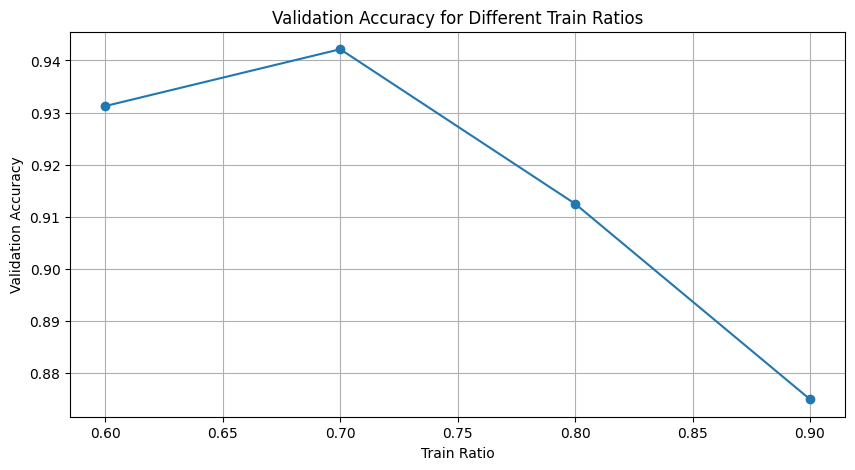

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

# Load MobileNetV3 from TensorFlow Hub
mobilenet_v3_large_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
mobilenet_v3_layer = hub.KerasLayer(mobilenet_v3_large_url, input_shape=(224, 224, 3), trainable=False)

# Function to load image paths and labels
def load_images_from_folders(main_dir, subdirs):
    images = []
    labels = []
    for subdir in subdirs:
        folder = os.path.join(main_dir, subdir)
        print(f"Checking folder: {folder}")  # Debug: Print the folder being checked
        if os.path.isdir(folder):
            for filename in os.listdir(folder):
                if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(folder, filename)
                    images.append(img_path)
                    labels.append(subdir)
    print(f"Total images loaded: {len(images)}")  # Debug: Print the total number of images loaded
    return np.array(images), np.array(labels)

# Function to create and compile the model
def create_model():
    model = Sequential([
        mobilenet_v3_layer,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate model for different train-test split ratios
def evaluate_model_for_ratios(main_dir, subdirs, ratios, image_size=(224, 224), batch_size=32, epochs=5):
    images, labels = load_images_from_folders(main_dir, subdirs)

    if len(images) == 0:
        raise ValueError("Dataset is empty. Please check the dataset directories.")

    best_ratio = None
    best_accuracy = 0
    results = []

    for ratio in ratios:
        train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1-ratio, random_state=42, stratify=labels)

        if len(train_images) == 0 or len(val_images) == 0:
            print(f"Skipping ratio {ratio} due to insufficient data.")
            continue

        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        val_generator = val_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        model = create_model()

        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)
        val_accuracy = history.history['val_accuracy'][-1]

        results.append((ratio, val_accuracy))

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_ratio = ratio

    return best_ratio, best_accuracy, results

# Define main directory and subdirectories
main_dir = '/content/drive/My Drive/Dataset-original-processing'
subdirs = ['LAKI-LAKI', 'PEREMPUAN']

# Define the ratios to be tested
ratios = [0.6, 0.7, 0.8, 0.9]

# Evaluate the model for different train-test split ratios
best_ratio, best_accuracy, results = evaluate_model_for_ratios(main_dir, subdirs, ratios)

# Print the best ratio and accuracy
print(f'Best Train-Test Split Ratio: {best_ratio}')
print(f'Best Validation Accuracy: {best_accuracy}')

# Plot the results
ratios, accuracies = zip(*results)
plt.figure(figsize=(10, 5))
plt.plot(ratios, accuracies, marker='o')
plt.xlabel('Train Ratio')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Train Ratios')
plt.grid(True)
plt.show()


Checking folder: /content/drive/My Drive/Gambar-preproces/LAKI-LAKI
Checking folder: /content/drive/My Drive/Gambar-preproces/PEREMPUAN
Total images loaded: 400
Found 240 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Epoch 1/5
8/8 [==============================] - 9s 724ms/step - loss: 0.5807 - accuracy: 0.7208 - val_loss: 0.2751 - val_accuracy: 0.9062
Epoch 2/5
8/8 [==============================] - 5s 637ms/step - loss: 0.2687 - accuracy: 0.8958 - val_loss: 0.2271 - val_accuracy: 0.8938
Epoch 3/5
8/8 [==============================] - 5s 616ms/step - loss: 0.1736 - accuracy: 0.9333 - val_loss: 0.1759 - val_accuracy: 0.9062
Epoch 4/5
8/8 [==============================] - 5s 632ms/step - loss: 0.0981 - accuracy: 0.9708 - val_loss: 0.1768 - val_accuracy: 0.8875
Epoch 5/5
8/8 [==============================] - 5s 622ms/step - loss: 0.0616 - accuracy: 0.9833 - val_loss: 0.1450 - val_accuracy: 0.9500
Found 279 validated imag

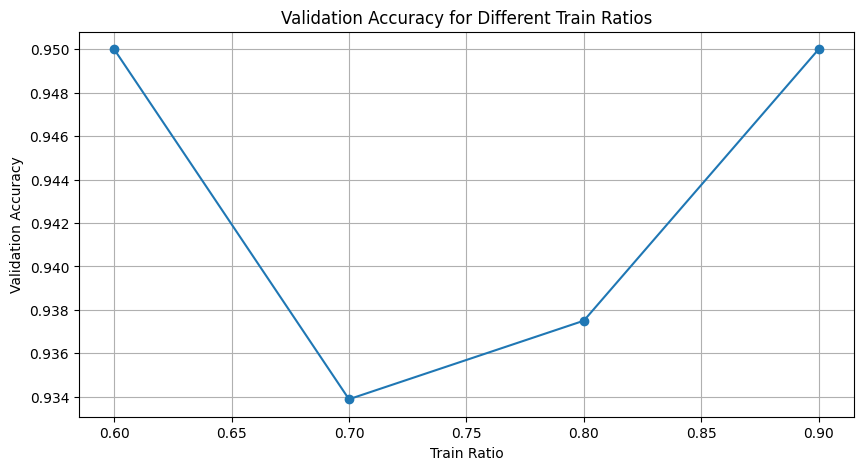

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

# Load MobileNetV3 from TensorFlow Hub
mobilenet_v3_large_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
mobilenet_v3_layer = hub.KerasLayer(mobilenet_v3_large_url, input_shape=(224, 224, 3), trainable=False)

# Function to load image paths and labels
def load_images_from_folders(main_dir, subdirs):
    images = []
    labels = []
    for subdir in subdirs:
        folder = os.path.join(main_dir, subdir)
        print(f"Checking folder: {folder}")  # Debug: Print the folder being checked
        if os.path.isdir(folder):
            for filename in os.listdir(folder):
                if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(folder, filename)
                    images.append(img_path)
                    labels.append(subdir)
    print(f"Total images loaded: {len(images)}")  # Debug: Print the total number of images loaded
    return np.array(images), np.array(labels)

# Function to create and compile the model
def create_model():
    model = Sequential([
        mobilenet_v3_layer,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate model for different train-test split ratios
def evaluate_model_for_ratios(main_dir, subdirs, ratios, image_size=(224, 224), batch_size=32, epochs=5):
    images, labels = load_images_from_folders(main_dir, subdirs)

    if len(images) == 0:
        raise ValueError("Dataset is empty. Please check the dataset directories.")

    best_ratio = None
    best_accuracy = 0
    results = []

    for ratio in ratios:
        train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1-ratio, random_state=42, stratify=labels)

        if len(train_images) == 0 or len(val_images) == 0:
            print(f"Skipping ratio {ratio} due to insufficient data.")
            continue

        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        val_generator = val_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        model = create_model()

        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)
        val_accuracy = history.history['val_accuracy'][-1]

        results.append((ratio, val_accuracy))

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_ratio = ratio

    return best_ratio, best_accuracy, results

# Define main directory and subdirectories
main_dir = '/content/drive/My Drive/Dataset-original-processing'
subdirs = ['LAKI-LAKI', 'PEREMPUAN']

# Define the ratios to be tested
ratios = [0.6, 0.7, 0.8, 0.9]

# Evaluate the model for different train-test split ratios
best_ratio, best_accuracy, results = evaluate_model_for_ratios(main_dir, subdirs, ratios)

# Print the best ratio and accuracy
print(f'Best Train-Test Split Ratio: {best_ratio}')
print(f'Best Validation Accuracy: {best_accuracy}')

# Plot the results
ratios, accuracies = zip(*results)
plt.figure(figsize=(10, 5))
plt.plot(ratios, accuracies, marker='o')
plt.xlabel('Train Ratio')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Train Ratios')
plt.grid(True)
plt.show()


Checking folder: /content/drive/My Drive/Gambar-preproces/LAKI-LAKI
Checking folder: /content/drive/My Drive/Gambar-preproces/PEREMPUAN
Total images loaded: 400
Found 240 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Epoch 1/5
8/8 [==============================] - 9s 732ms/step - loss: 0.5440 - accuracy: 0.6917 - val_loss: 0.2988 - val_accuracy: 0.9000
Epoch 2/5
8/8 [==============================] - 5s 632ms/step - loss: 0.2402 - accuracy: 0.9125 - val_loss: 0.1793 - val_accuracy: 0.9500
Epoch 3/5
8/8 [==============================] - 5s 612ms/step - loss: 0.1652 - accuracy: 0.9208 - val_loss: 0.1843 - val_accuracy: 0.9312
Epoch 4/5
8/8 [==============================] - 5s 612ms/step - loss: 0.1024 - accuracy: 0.9667 - val_loss: 0.1814 - val_accuracy: 0.9438
Epoch 5/5
8/8 [==============================] - 5s 636ms/step - loss: 0.0705 - accuracy: 0.9833 - val_loss: 0.2372 - val_accuracy: 0.8875
Found 279 validated imag

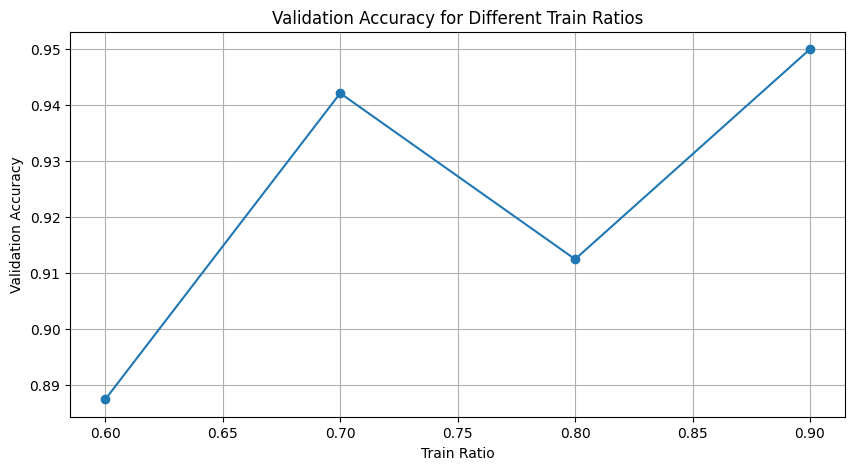

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

# Load MobileNetV3 from TensorFlow Hub
mobilenet_v3_large_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
mobilenet_v3_layer = hub.KerasLayer(mobilenet_v3_large_url, input_shape=(224, 224, 3), trainable=False)

# Function to load image paths and labels
def load_images_from_folders(main_dir, subdirs):
    images = []
    labels = []
    for subdir in subdirs:
        folder = os.path.join(main_dir, subdir)
        print(f"Checking folder: {folder}")  # Debug: Print the folder being checked
        if os.path.isdir(folder):
            for filename in os.listdir(folder):
                if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(folder, filename)
                    images.append(img_path)
                    labels.append(subdir)
    print(f"Total images loaded: {len(images)}")  # Debug: Print the total number of images loaded
    return np.array(images), np.array(labels)

# Function to create and compile the model
def create_model():
    model = Sequential([
        mobilenet_v3_layer,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate model for different train-test split ratios
def evaluate_model_for_ratios(main_dir, subdirs, ratios, image_size=(224, 224), batch_size=32, epochs=5):
    images, labels = load_images_from_folders(main_dir, subdirs)

    if len(images) == 0:
        raise ValueError("Dataset is empty. Please check the dataset directories.")

    best_ratio = None
    best_accuracy = 0
    results = []

    for ratio in ratios:
        train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1-ratio, random_state=42, stratify=labels)

        if len(train_images) == 0 or len(val_images) == 0:
            print(f"Skipping ratio {ratio} due to insufficient data.")
            continue

        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        val_generator = val_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        model = create_model()

        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)
        val_accuracy = history.history['val_accuracy'][-1]

        results.append((ratio, val_accuracy))

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_ratio = ratio

    return best_ratio, best_accuracy, results

# Define main directory and subdirectories
main_dir = '/content/drive/My Drive/Dataset-original-processing'
subdirs = ['LAKI-LAKI', 'PEREMPUAN']

# Define the ratios to be tested
ratios = [0.6, 0.7, 0.8, 0.9]

# Evaluate the model for different train-test split ratios
best_ratio, best_accuracy, results = evaluate_model_for_ratios(main_dir, subdirs, ratios)

# Print the best ratio and accuracy
print(f'Best Train-Test Split Ratio: {best_ratio}')
print(f'Best Validation Accuracy: {best_accuracy}')

# Plot the results
ratios, accuracies = zip(*results)
plt.figure(figsize=(10, 5))
plt.plot(ratios, accuracies, marker='o')
plt.xlabel('Train Ratio')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Train Ratios')
plt.grid(True)
plt.show()


Checking folder: /content/drive/My Drive/Gambar-preproces/LAKI-LAKI
Checking folder: /content/drive/My Drive/Gambar-preproces/PEREMPUAN
Total images loaded: 400
Found 240 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Epoch 1/5
8/8 [==============================] - 9s 696ms/step - loss: 0.6183 - accuracy: 0.6708 - val_loss: 0.3939 - val_accuracy: 0.8125
Epoch 2/5
8/8 [==============================] - 5s 631ms/step - loss: 0.3245 - accuracy: 0.8417 - val_loss: 0.2520 - val_accuracy: 0.8875
Epoch 3/5
8/8 [==============================] - 5s 619ms/step - loss: 0.2097 - accuracy: 0.9208 - val_loss: 0.1894 - val_accuracy: 0.9500
Epoch 4/5
8/8 [==============================] - 5s 643ms/step - loss: 0.1243 - accuracy: 0.9542 - val_loss: 0.1563 - val_accuracy: 0.9187
Epoch 5/5
8/8 [==============================] - 5s 617ms/step - loss: 0.0919 - accuracy: 0.9667 - val_loss: 0.1687 - val_accuracy: 0.9125
Found 279 validated imag

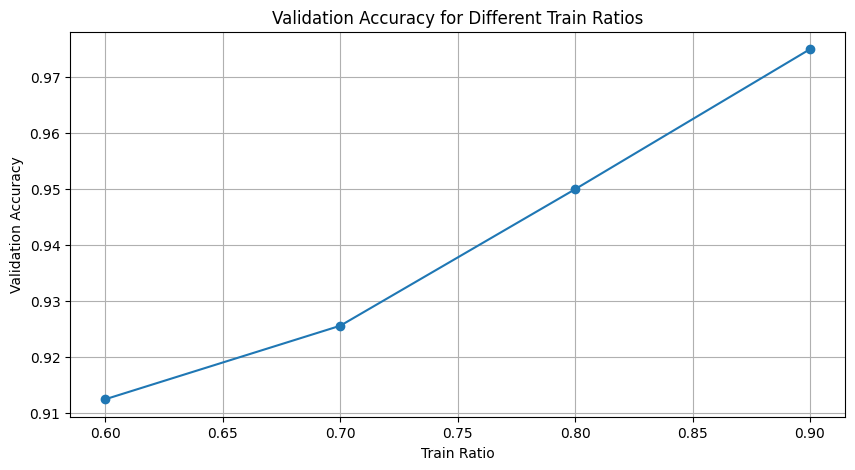

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

# Load MobileNetV3 from TensorFlow Hub
mobilenet_v3_large_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
mobilenet_v3_layer = hub.KerasLayer(mobilenet_v3_large_url, input_shape=(224, 224, 3), trainable=False)

# Function to load image paths and labels
def load_images_from_folders(main_dir, subdirs):
    images = []
    labels = []
    for subdir in subdirs:
        folder = os.path.join(main_dir, subdir)
        print(f"Checking folder: {folder}")  # Debug: Print the folder being checked
        if os.path.isdir(folder):
            for filename in os.listdir(folder):
                if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(folder, filename)
                    images.append(img_path)
                    labels.append(subdir)
    print(f"Total images loaded: {len(images)}")  # Debug: Print the total number of images loaded
    return np.array(images), np.array(labels)

# Function to create and compile the model
def create_model():
    model = Sequential([
        mobilenet_v3_layer,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate model for different train-test split ratios
def evaluate_model_for_ratios(main_dir, subdirs, ratios, image_size=(224, 224), batch_size=32, epochs=5):
    images, labels = load_images_from_folders(main_dir, subdirs)

    if len(images) == 0:
        raise ValueError("Dataset is empty. Please check the dataset directories.")

    best_ratio = None
    best_accuracy = 0
    results = []

    for ratio in ratios:
        train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1-ratio, random_state=42, stratify=labels)

        if len(train_images) == 0 or len(val_images) == 0:
            print(f"Skipping ratio {ratio} due to insufficient data.")
            continue

        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        val_generator = val_datagen.flow_from_dataframe(
            dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
            x_col='filename',
            y_col='class',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        model = create_model()

        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1)
        val_accuracy = history.history['val_accuracy'][-1]

        results.append((ratio, val_accuracy))

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_ratio = ratio

    return best_ratio, best_accuracy, results

# Define main directory and subdirectories
main_dir = '/content/drive/My Drive/Dataset-original-processing'
subdirs = ['LAKI-LAKI', 'PEREMPUAN']

# Define the ratios to be tested
ratios = [0.6, 0.7, 0.8, 0.9]

# Evaluate the model for different train-test split ratios
best_ratio, best_accuracy, results = evaluate_model_for_ratios(main_dir, subdirs, ratios)

# Print the best ratio and accuracy
print(f'Best Train-Test Split Ratio: {best_ratio}')
print(f'Best Validation Accuracy: {best_accuracy}')

# Plot the results
ratios, accuracies = zip(*results)
plt.figure(figsize=(10, 5))
plt.plot(ratios, accuracies, marker='o')
plt.xlabel('Train Ratio')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Train Ratios')
plt.grid(True)
plt.show()


***SPLITTING DATA***

In [ ]:
import os
import random
import shutil

# Function to split dataset into training and testing sets
def splitting_data(dataset, train, test, train_ratio):
    # Ensure the training and testing directories exist
    os.makedirs(train, exist_ok=True)
    os.makedirs(test, exist_ok=True)

    # Get list of files in the dataset directory
    files = [f for f in os.listdir(dataset) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    total_size = len(files)
    train_size = int(train_ratio * total_size)
    test_size = total_size - train_size

    # Shuffle files randomly
    random.shuffle(files)
    train_files = files[:train_size]
    test_files = files[train_size:]

    # Copy files to their respective training and testing directories
    for file in train_files:
        src = os.path.join(dataset, file)
        dst = os.path.join(train, file)
        shutil.copyfile(src, dst)
    for file in test_files:
        src = os.path.join(dataset, file)
        dst = os.path.join(test, file)
        shutil.copyfile(src, dst)

# Define directory paths, assuming your dataset is in 'My Drive' within Google Drive
dataset_dir = '/content/drive/My Drive/Dataset-original-processing'
train_dir = '/content/drive/My Drive/Dataset-original-processing-train'
test_dir = '/content/drive/My Drive/Dataset-original-processing-test'
# Define specific subdirectory paths for LAKI-LAKI and PEREMPUAN
laki_dir = os.path.join(dataset_dir, 'LAKI-LAKI')
train_laki = os.path.join(train_dir, 'LAKI-LAKI')
test_laki = os.path.join(test_dir, 'LAKI-LAKI')

perempuan_dir = os.path.join(dataset_dir, 'PEREMPUAN')
train_perempuan = os.path.join(train_dir, 'PEREMPUAN')
test_perempuan = os.path.join(test_dir, 'PEREMPUAN')

# Training data ratio
train_ratio = 0.9

# Split data for LAKI-LAKI
splitting_data(laki_dir, train_laki, test_laki, train_ratio)

# Split data for PEREMPUAN
splitting_data(perempuan_dir, train_perempuan, test_perempuan, train_ratio)

# Display totals and counts of split data
print('Jumlah Total Laki-Laki: ', len(os.listdir(laki_dir)))
print('Jumlah Data Train Laki-Laki: ', len(os.listdir(train_laki)))
print('Jumlah Data Test Laki-Laki: ', len(os.listdir(test_laki)))
print()
print('Jumlah Total Perempuan: ', len(os.listdir(perempuan_dir)))
print('Jumlah Data Train Perempuan: ', len(os.listdir(train_perempuan)))
print('Jumlah Data Test Perempuan: ', len(os.listdir(test_perempuan)))


Jumlah Total Laki-Laki:  200
Jumlah Data Train Laki-Laki:  180
Jumlah Data Test Laki-Laki:  20

Jumlah Total Perempuan:  200
Jumlah Data Train Perempuan:  180
Jumlah Data Test Perempuan:  20


**AUGMENTASI (JANGAN DI RUN)**

In [ ]:
# Import Library
import os
import cv2
from google.colab import drive

def augmentasi_citra(image, rotation_degrees):
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), rotation_degrees, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

In [ ]:
def augmentasi_flip_horizontal(image):
    flipped_horizontally = cv2.flip(image, 1)
    return flipped_horizontally

In [ ]:
def augmentasi_citra_height_shift(image, shift_fraction):
    rows, cols, _ = image.shape
    M = np.float32([[1, 0, 0], [0, 1, shift_fraction * rows]])
    shifted_image = cv2.warpAffine(image, M, (cols, rows))
    return shifted_image

In [ ]:
def main():
    # Update path untuk mengakses Google Drive
    dataset_dir = '/content/drive/My Drive/Dataset-original-processing-train'
    augmented_dataset_dir = '/content/drive/My Drive/Dataset-original-processing-train-augmentasi'
    os.makedirs(augmented_dataset_dir, exist_ok=True)

    for imageClass in os.listdir(dataset_dir):
        class_dir = os.path.join(augmented_dataset_dir, imageClass)
        os.makedirs(class_dir, exist_ok=True)
        class_path = os.path.join(dataset_dir, imageClass)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                img = cv2.imread(image_path)
                if img is not None:
                    # Save the original image
                    cv2.imwrite(os.path.join(class_dir, f'original_{image_file}'), img)

                    # Save the image rotated by 15 degrees (both directions)
                    augmented_img_15_left = augmentasi_citra(img, 15)
                    augmented_img_15_right = augmentasi_citra(img, -15)
                    cv2.imwrite(os.path.join(class_dir, f'left_15_{image_file}'), augmented_img_15_left)
                    cv2.imwrite(os.path.join(class_dir, f'right_15_{image_file}'), augmented_img_15_right)

                    # Save the height-shifted images (up and down)
                    augmented_img_shift_up = augmentasi_citra_height_shift(img, 0.1)
                    augmented_img_shift_down = augmentasi_citra_height_shift(img, -0.1)
                    cv2.imwrite(os.path.join(class_dir, f'shift_up_{image_file}'), augmented_img_shift_up)
                    cv2.imwrite(os.path.join(class_dir, f'shift_down_{image_file}'), augmented_img_shift_down)

                    # Save the horizontally flipped image
                    flipped_horizontal = augmentasi_flip_horizontal(img)
                    cv2.imwrite(os.path.join(class_dir, f'horizontal_flip_{image_file}'), flipped_horizontal)

if __name__ == "__main__":
    main()

In [ ]:
# Rename file gambar yang sudah di augmentasi
import os

def rename_files(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if not file_name.endswith("_augmented"):
                original_path = os.path.join(root, file_name)
                new_file_name = file_name.split('.')[0] + "_augmented." + file_name.split('.')[1]
                new_path = os.path.join(root, new_file_name)

                # Jika nama file sudah ada, tambahkan nomor unik
                count = 1
                while os.path.exists(new_path):
                    new_file_name = file_name.split('.')[0] + f"augmented{count}." + file_name.split('.')[1]
                    new_path = os.path.join(root, new_file_name)
                    count += 1

                os.rename(original_path, new_path)


In [ ]:
def main():
    augmented_dataset_dir = 'augmentasi_data'
    rename_files(augmented_dataset_dir)

if __name__ == "__main__":
    main()

In [ ]:
dataset_dir = '/content/drive/My Drive/Dataset-original-processing-train-augmentasi'

laki_dir = os.path.join(dataset_dir, 'LAKI-LAKI')
perempuan_dir = os.path.join(dataset_dir, 'PEREMPUAN')

os.makedirs(laki_dir, exist_ok=True)
os.makedirs(perempuan_dir, exist_ok=True)

print("Jumlah data Laki-Laki: ", len(os.listdir(laki_dir)))
print("Jumlah data Perempuan: ", len(os.listdir(perempuan_dir)))

Jumlah data Laki-Laki:  1080
Jumlah data Perempuan:  1080


MODEL

In [ ]:
from skimage import io, color
from skimage.feature import local_binary_pattern
import numpy as np
import os
import dlib
from skimage.color import rgb2gray
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Large
import tensorflow as tf

In [ ]:
def extract_lbp_features(gray_image, P=8, R=1, grid_size=(7, 7)):
    height, width = gray_image.shape
    grid_h, grid_w = grid_size
    step_h, step_w = height // grid_h, width // grid_w

    lbp_features = []

    for i in range(0, height, step_h):
        for j in range(0, width, step_w):
            grid = gray_image[i:i + step_h, j:j + step_w]  # Perbaiki di sini
            if grid.shape[0] == 0 or grid.shape[1] == 0:
                continue

            lbp = local_binary_pattern(grid, P, R, method='uniform')
            (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)
            lbp_features.extend(hist)

    return np.array(lbp_features)

In [ ]:
def apply_asm(gray_image, predictor_path, face_detector):
    gray_image = (gray_image * 224).astype(np.uint8)  # Ensure the image is 8-bit grayscale
    faces = face_detector(gray_image, 1)
    shape_predictor = dlib.shape_predictor(predictor_path)

    if len(faces) == 0:
        # If no faces detected, return zero array
        return np.zeros(81 * 2)

    for face in faces:
        # Predict face shape
        shape = shape_predictor(gray_image, face)
        coords = np.zeros((81, 2), dtype='int')
        # Extract facial landmark coordinates
        for i in range(0, 81):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        return coords.flatten()

    # If no faces detected, return zero array
    return np.zeros(81 * 2)

In [ ]:
import cv2
import dlib
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fungsi untuk menerapkan ASM pada gambar grayscale
def extract_landmarks(gray_image, predictor_path, face_detector):
    # Pastikan gambar adalah grayscale
    if len(gray_image.shape) == 3 and gray_image.shape[2] == 3:
        gray_image = cv2.cvtColor(gray_image, cv2.COLOR_BGR2GRAY)

    faces = face_detector(gray_image, 1)
    shape_predictor = dlib.shape_predictor(predictor_path)

    if len(faces) == 0:
        return None

    for face in faces:
        # Memprediksi bentuk wajah
        shape = shape_predictor(gray_image, face)
        coords = np.zeros((68, 2), dtype='int')
        # Ekstraksi koordinat landmark wajah
        for i in range(0, 68):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        asm_coordinates = coords.flatten()
        return asm_coordinates

    return None

In [ ]:
# Fungsi untuk mengumpulkan landmark wajah dari semua gambar dalam direktori
def collect_landmarks(directory_path, predictor_path, face_detector):
    landmarks_list = []

    # Loop melalui semua file dalam direktori dan subdirektori
    for subdir, _, files in os.walk(directory_path):
        for file in files:
            # Hanya memproses file gambar (jpg, png, dll)
            if file.endswith(('jpg', 'jpeg', 'png')):
                file_path = os.path.join(subdir, file)
                image = cv2.imread(file_path)
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                landmarks = extract_landmarks(gray_image, predictor_path, face_detector)
                if landmarks is not None:
                    landmarks_list.append(landmarks)

    return np.array(landmarks_list)


In [ ]:
# Fungsi untuk menampilkan gambar dan hasil eigenvektor
def process_and_display_image(image_path, predictor_path, face_detector, pca_model):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    landmarks = extract_landmarks(gray_image, predictor_path, face_detector)
    eigenvectors = pca_model.transform([landmarks])[0] if landmarks is not None else np.zeros(pca_model.n_components)

    # Menampilkan gambar asli
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Menampilkan hasil eigenvektor
    plt.subplot(1, 2, 2)
    plt.plot(eigenvectors, 'o-')
    plt.title('Eigenvectors from ASM')
    plt.xlabel('Component')
    plt.ylabel('Value')
    plt.grid(True)

    plt.show()


Collected 2046 sets of landmarks.


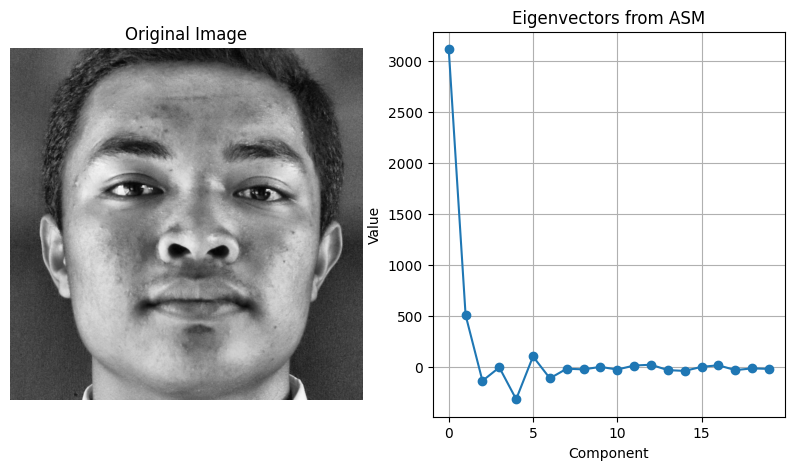

In [ ]:
# Path ke model prediktor wajah
predictor_path = '/content/drive/My Drive/shape_predictor_81_face_landmarks.dat'
face_detector = dlib.get_frontal_face_detector()

# Path ke direktori gambar
directory_path = '/content/drive/My Drive/Dataset-original-processing-train-augmentasi'

# Mengumpulkan landmark wajah dari semua gambar dalam direktori
landmarks_dataset = collect_landmarks(directory_path, predictor_path, face_detector)
print(f"Collected {len(landmarks_dataset)} sets of landmarks.")

# Latih PCA pada set data landmark wajah yang dikumpulkan
pca = PCA(n_components=20)  # Tentukan jumlah komponen utama
pca.fit(landmarks_dataset)

# Path ke gambar untuk diproses dan ditampilkan
image_path = '/content/drive/My Drive/augmentasi_Data-TA/LAKI-LAKI/original_processed_14S23023_Jusen Samosir.jpg'

# Proses dan tampilkan gambar beserta hasil eigenvektor
process_and_display_image(image_path, predictor_path, face_detector, pca)


In [ ]:
def combine_features(lbp_features, asm_features):
    # Function to combine LBP and ASM features
    return np.concatenate((lbp_features, asm_features))

In [ ]:
def process_specific_directories(base_dir, sub_dirs, predictor_path, face_detector):
    combined_features_list = []
    shape_predictor = dlib.shape_predictor(predictor_path)  # Load the shape predictor once

    for sub_dir in sub_dirs:
        current_dir = os.path.join(base_dir, sub_dir)
        if not os.path.exists(current_dir):
            #print("Subdirectory not found:", current_dir)
            continue
        #print(f"Processing {sub_dir}...")

        for filename in os.listdir(current_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(current_dir, filename)  # Corrected variable name
                image = io.imread(file_path)
                if image.ndim == 3:
                    image = rgb2gray(image)

                # Now apply ASM with all required parameters
                asm_features = apply_asm(image, predictor_path, face_detector)
                lbp_features = extract_lbp_features(image)
                combined_features = combine_features(lbp_features, asm_features)
                combined_features_list.append(combined_features)
                #print(f'Combined features for {filename} from {current_dir}:', combined_features)
    return combined_features_list

    # Example usage:
train_dir = '/content/drive/My Drive/Dataset-original-processing-train-augmentasi'
test_dir = '/content/drive/My Drive/Dataset-original-processing-test'
sub_dirs = ['LAKI-LAKI', 'PEREMPUAN']

predictor_path = '/content/drive/My Drive/shape_predictor_81_face_landmarks.dat'
face_detector = dlib.get_frontal_face_detector()

In [ ]:
# Function to convert grayscale LBP and ASM features to RGB
def convert_grayscale_to_rgb(image, lbp_features, asm_features):
    # Assuming LBP and ASM features are concatenated and flattened
    combined_features = np.concatenate((lbp_features, asm_features), axis=None)
    # Normalize combined features to the range [0, 255]
    combined_features = (combined_features - combined_features.min()) / (combined_features.max() - combined_features.min()) * 255
    combined_features = combined_features.astype(np.uint8)
    # Reshape to the required shape, here we assume 1x1 RGB image for simplicity
    rgb_features = np.stack((combined_features,)*3, axis=-1).reshape((1, 224, 224, 3))
    return rgb_features

In [ ]:
def extract_data_from_generator(generator, num_batches):
    data = []
    labels = []

    for _ in range(num_batches):
        batch_data, batch_labels = next(generator)
        data.extend(batch_data)
        labels.extend(batch_labels)
    return np.array(data), np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def stratified_sampling(data, labels, batch_size):
    male_data = [data[i] for i in range(len(labels)) if labels[i] == 0]  # Asumsi label 0 untuk laki-laki
    female_data = [data[i] for i in range(len(labels)) if labels[i] == 1]  # Asumsi label 1 untuk perempuan

    male_labels = [0] * len(male_data)
    female_labels = [1] * len(female_data)

    male_data, female_data, male_labels, female_labels = np.array(male_data), np.array(female_data), np.array(male_labels), np.array(female_labels)

    samples_per_category = batch_size // 2

    while len(male_data) >= samples_per_category and len(female_data) >= samples_per_category:
        male_batch = male_data[:samples_per_category]
        female_batch = female_data[:samples_per_category]

        male_batch_labels = male_labels[:samples_per_category]
        female_batch_labels = female_labels[:samples_per_category]

        batch_data = np.concatenate([male_batch, female_batch], axis=0)
        batch_labels = np.concatenate([male_batch_labels, female_batch_labels], axis=0)

        yield batch_data, batch_labels

        male_data = male_data[samples_per_category:]
        female_data = female_data[samples_per_category:]

        male_labels = male_labels[samples_per_category:]
        female_labels = female_labels[samples_per_category:]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerators with rescaling and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Adding validation split to separate 20% of training data for validation
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Set up the paths to your training and testing data
train_dir = '/content/drive/My Drive/Dataset-original-processing-train-augmentasi'
test_dir = '/content/drive/My Drive/Dataset-original-processing-test'

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory with training data
    target_size=(224, 224),
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Same directory as training data
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Directory with test data
    target_size=(224, 224),
    class_mode='categorical'
)


Found 1911 images belonging to 2 classes.
Found 477 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Load MobileNetV3 from TensorFlow Hub
mobilenet_v3_large_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
mobilenet_v3_layer = hub.KerasLayer(mobilenet_v3_large_url, input_shape=(224, 224, 3), trainable=False)

# Function to create model with specified learning rate
def create_model(learning_rate, total_features):
    # Input for images to MobileNetV3
    input_image = Input(shape=(224, 224, 3), name='image_input')
    # Input for LBP and ASM features
    input_lbp_asm = Input(shape=(total_features,), name='lbp_asm_input')

    # MobileNetV3 from TensorFlow Hub
    x = mobilenet_v3_layer(input_image)

    # Check shape of MobileNetV3 output
    print(f'Shape of MobileNetV3 output: {x.shape}')

    # Flatten the MobileNetV3 output
    x = Flatten()(x)

    # Fully connected layer for LBP and ASM features
    y = Dense(128, activation='relu')(input_lbp_asm)

    # Concatenate features from MobileNetV3 and LBP+ASM
    combined = Concatenate()([x, y])

    # Add some fully connected layers
    z = Dense(256, activation='relu')(combined)
    z = Dense(128, activation='relu')(z)
    output = Dense(2, activation='softmax')(z)

    # Create model
    model = Model(inputs=[input_image, input_lbp_asm], outputs=output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Example: Total features calculated from LBP and ASM
total_features = 8 * 7 * 7 + 81 * 2

In [ ]:
# Print model summary
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_39 (InputLayer)       [(None, 1288)]               0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 1280)                 4226432   ['input_38[0][0]']            
                                                                                                  
 dense_65 (Dense)            (None, 128)                  164992    ['input_39[0][0]']            
                                                                                           

In [ ]:
def process_batches_for_training_stratified(generator, num_batches=10, batch_size=32):
    all_data, all_labels = extract_data_from_generator(generator, num_batches)

    stratified_batches = stratified_sampling(all_data, all_labels, batch_size)

    X_lbp_asm = []
    X_images = []
    y_labels = []

    for batch_data, batch_labels in stratified_batches:
        for image, label in zip(batch_data, batch_labels):
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert once here
            lbp_features = extract_lbp_features(gray_image)
            asm_coords = apply_asm(gray_image, predictor_path, face_detector)
            combined_features = combine_features(lbp_features, asm_coords)
            X_lbp_asm.append(combined_features)
            X_images.append(image)
            y_labels.append(label)

    return np.array(X_images), np.array(X_lbp_asm), np.array(y_labels)


In [ ]:
from concurrent.futures import ThreadPoolExecutor

def process_single_batch(generator):
    sample_batch, labels = next(generator)
    X_lbp_asm, X_images, y_labels = [], [], []
    for image, label in zip(sample_batch, labels):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert once here
        lbp_features = extract_lbp_features(gray_image)
        asm_coords = apply_asm(gray_image, predictor_path, face_detector)
        combined_features = combine_features(lbp_features, asm_coords)
        X_lbp_asm.append(combined_features)
        X_images.append(image)
        y_labels.append(label)

    return np.array(X_images), np.array(X_lbp_asm), np.array(y_labels)

In [ ]:
# Function to process batches for training and validation
def process_batches_for_training_parallel(generator, num_batches):
    X_images = []
    X_lbp_asm = []
    y = []

    for _ in range(num_batches):
        # Generate a batch of data
        images, labels = next(generator)

        for img in images:
            # Compute LBP features (dummy example, replace with actual computation)
            lbp_features = compute_lbp_features(img)

            # Compute ASM features (dummy example, replace with actual computation)
            asm_features = compute_asm_features(img)

            # Concatenate LBP and ASM features
            combined_features = np.concatenate((lbp_features, asm_features))

            X_images.append(img)
            X_lbp_asm.append(combined_features)

        y.extend(labels)

    return np.array(X_images), np.array(X_lbp_asm), np.array(y)

In [ ]:
def compute_lbp_features(img):
    # Replace with actual LBP computation
    return np.random.rand(16 * 8 * 8)

def compute_asm_features(img):
    # Replace with actual ASM computation
    return np.random.rand(81 * 2)

In [ ]:
# Initialize and process batches once
X_images_train, X_lbp_asm_train, y_train = process_batches_for_training_parallel(train_generator, num_batches=10)
X_images_val, X_lbp_asm_val, y_val = process_batches_for_training_parallel(validation_generator, num_batches=5)

In [ ]:
import pandas as pd
import tensorflow as tf

# Ensure labels are one-hot encoded if using 'categorical_crossentropy'
num_classes = 10
if y_train.ndim == 1:
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Calculate the number of features
lbp_features_count = 16 * 8 * 8  # Assuming LBP produces 392 features
asm_features_count = 81 * 2  # 81 landmarks, each with 2 coordinates

# Calculate total_features based on actual features
total_features = lbp_features_count + asm_features_count

print(f"Calculated total_features: {total_features}")

# Proses batch untuk data training dan validation dengan parallel processing
X_images_train, X_lbp_asm_train, y_train = process_batches_for_training_parallel(train_generator, num_batches=10)
X_images_val, X_lbp_asm_val, y_val = process_batches_for_training_parallel(validation_generator, num_batches=5)

# Debugging: Print shapes of the data
print(f"Shape of X_images_train: {X_images_train.shape}")
print(f"Shape of X_lbp_asm_train: {X_lbp_asm_train.shape}")
print(f"Expected LBP+ASM input shape: {total_features}")

# Ensure the shapes are correct
assert X_images_train.shape[1:] == (224, 224, 3), "Image input shape is incorrect"
assert X_lbp_asm_train.shape[1] == total_features, f"LBP+ASM input shape is incorrect: Expected {total_features}, but got {X_lbp_asm_train.shape[1]}"


Calculated total_features: 1186


KeyboardInterrupt: 

In [ ]:
import cv2

# Bagian 1: Inisialisasi dan Proses Batch Sekali Saja
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.00005, 0.0005, 0.005, 0.05, 0.5]
batch_sizes = [16, 32, 64, 128]
epoch_range = range(100, 200, 100)  # Range from 100 to 1000 with step of 100
best_accuracy = 0
best_params = {}
results = []

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint('/content/drive/My Drive/model_3Juli.h5', monitor='val_accuracy', save_best_only=True)
]

In [ ]:
# Loop through the hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in epoch_range:
            print(f"\nTraining with learning rate: {lr}, batch size: {batch_size}, and epochs: {epochs}")
            final_model = create_model(learning_rate=lr, total_features=total_features)

            # Train the model
            history = final_model.fit(
                [X_images_train, X_lbp_asm_train], y_train,
                validation_data=([X_images_val, X_lbp_asm_val], y_val),
                batch_size=batch_size, epochs=epochs, callbacks=callbacks
            )

            # Evaluate the model using validation data
            val_loss, val_acc = final_model.evaluate([X_images_val, X_lbp_asm_val], y_val)
            print(f"Validation Accuracy with learning rate {lr}, batch size {batch_size}, and epochs {epochs}: {val_acc}")

            # Update the best accuracy and parameters if the current model is better
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {'learning_rate': lr, 'batch_size': batch_size, 'epochs': epochs}
                print(f"New best params: {best_params} with validation accuracy: {best_accuracy}")

            # Store the results
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'epochs': epochs,
                'val_accuracy': val_acc,
                'val_loss': val_loss
            })

# Display the best parameters and accuracy
print(f"\nBest parameters: {best_params} with validation accuracy: {best_accuracy}")

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/My Drive/gridsearch_mobilenet.csv', index=False)
print(results_df)



Training with learning rate: 1e-05, batch size: 16, and epochs: 100
Shape of MobileNetV3 output: (None, 1280)
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.0333 - accuracy: 0.4625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 84/100
3/3 [==============================] - 3s 1s/step - loss: 3.7379e-05 - accuracy: 1.0000 - val_loss: 0.4884 - val_accuracy: 0.9500
Epoch 85/100
3/3 [==============================] - 3s 1s/step - loss: 3.6736e-05 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 0.9500
Epoch 86/100
3/3 [==============================] - 4s 1s/step - loss: 3.6113e-05 - accuracy: 1.0000 - val_loss: 0.4903 - val_accuracy: 0.9500
Epoch 87/100
3/3 [==============================] - 3s 1s/step - loss: 3.5431e-05 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.9500
Epoch 88/100
3/3 [==============================] - 3s 1s/step - loss: 3.4797e-05 - accuracy: 1.0000 - val_loss: 0.4918 - val_accuracy: 0.9500
Epoch 89/100
3/3 [==============================] - 3s 1s/step - loss: 3.4148e-05 - accuracy: 1.0000 - val_loss: 0.4927 - val_accuracy: 0.9500
Epoch 90/100
3/3 [==============================] - 4s 1s/step - loss: 3.3525e-05 -

In [ ]:
# import tensorflow as tf

# # Load MobileNetV3 from TensorFlow Keras Applications
# mobilenet_v3 = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3),
#                                                       include_top=False,  # Exclude the final classification layer
#                                                       weights='imagenet')

# # Print the summary of MobileNetV3 to see all internal layers
# mobilenet_v3.summary()


12683000/12683000 [==============================] - 1s 0us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_56 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_56[0][0]']            
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)        

In [ ]:
# Model summary
final_model.summary()

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_94 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_95 (InputLayer)       [(None, 1288)]               0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 1280)                 4226432   ['input_94[0][0]']            
                                                                                                  
 dense_183 (Dense)           (None, 128)                  164992    ['input_95[0][0]']            
                                                                                           

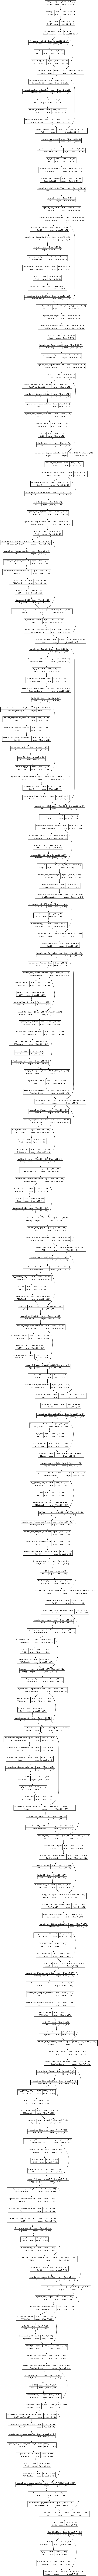

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.utils import plot_model

# # Load MobileNetV3 from TensorFlow Keras Applications
# mobilenet_v3 = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3),
#                                                       include_top=False,  # Exclude the final classification layer
#                                                       weights='imagenet')


# # Plot the model
# plot_model(mobilenet_v3, to_file='mobilenetv3_large.png', show_shapes=True, show_layer_names=True)


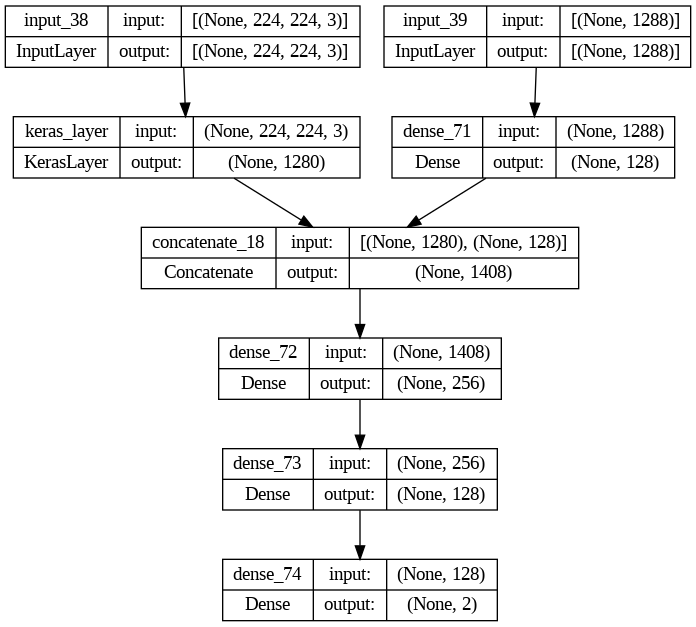

In [ ]:
# from tensorflow.keras.utils import plot_model
# import tensorflow_hub as hub
# from tensorflow.keras.models import load_model
# import tensorflow as tf

# # Define a custom object scope that includes the KerasLayer from TensorFlow Hub
# custom_objects = {'KerasLayer': hub.KerasLayer}

# # Load model with custom object scope
# model_path = '/content/drive/My Drive/model_25Juni_ImageProcessingCLahe.h5'
# model = load_model(model_path, custom_objects=custom_objects)

# # Plot the model
# plot_model(model, to_file='mobilenetv3large.png', show_shapes=True, show_layer_names=True)


In [ ]:
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Batch Size: {result['batch_size']}, Epochs: {result['epochs']}, Validation Accuracy: {result['val_accuracy']}")

# Bagian 3: Pelatihan Model Akhir dengan Parameter Terbaik
if best_params:
    final_model = create_model(learning_rate=best_params['learning_rate'], total_features=total_features)

    # Melatih model dengan data yang telah diproses
    history = final_model.fit(
        [X_images_train, X_lbp_asm_train], y_train,
        epochs=best_params['epochs'],
        validation_data=([X_images_val, X_lbp_asm_val], y_val),
        batch_size=best_params['batch_size'],
        callbacks=callbacks
    )
else:
    print("No best parameters found. Ensure that the grid search updated best_params.")

Learning Rate: 1e-05, Batch Size: 16, Epochs: 100, Validation Accuracy: 0.918749988079071
Learning Rate: 1e-05, Batch Size: 32, Epochs: 100, Validation Accuracy: 0.90625
Learning Rate: 1e-05, Batch Size: 64, Epochs: 100, Validation Accuracy: 0.875
Learning Rate: 1e-05, Batch Size: 128, Epochs: 100, Validation Accuracy: 0.875
Learning Rate: 0.0001, Batch Size: 16, Epochs: 100, Validation Accuracy: 0.918749988079071
Learning Rate: 0.0001, Batch Size: 32, Epochs: 100, Validation Accuracy: 0.8999999761581421
Learning Rate: 0.0001, Batch Size: 64, Epochs: 100, Validation Accuracy: 0.949999988079071
Learning Rate: 0.0001, Batch Size: 128, Epochs: 100, Validation Accuracy: 0.9312499761581421
Learning Rate: 0.001, Batch Size: 16, Epochs: 100, Validation Accuracy: 0.9437500238418579
Learning Rate: 0.001, Batch Size: 32, Epochs: 100, Validation Accuracy: 0.9437500238418579
Learning Rate: 0.001, Batch Size: 64, Epochs: 100, Validation Accuracy: 0.9312499761581421
Learning Rate: 0.001, Batch Size:

In [ ]:
# Bagian 4: Evaluasi Model Akhir dengan Data Uji
# Proses batch untuk data testing sekali saja setelah semua pelatihan selesai
X_test_images, X_test_lbp_asm, y_test_labels = process_batches_for_training_parallel(test_generator, num_batches=len(test_generator))

# Evaluasi model menggunakan test data
test_loss, test_acc = final_model.evaluate([X_test_images, X_test_lbp_asm], y_test_labels)
print(f"Test Accuracy: {test_acc}")

2/2 [==============================] - 0s 60ms/step - loss: 0.2425 - accuracy: 0.9750
Test Accuracy: 0.9750000238418579


In [ ]:
!pip install flatbuffers

In [ ]:
import flatbuffers
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

# Define a custom object scope that includes the KerasLayer from TensorFlow Hub
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the Keras model
model_path = '/content/drive/My Drive/model_1Juli.h5'
with tf.keras.utils.custom_object_scope(custom_objects):
    final_model = load_model(model_path)

# Function to convert the model to TFLite format
def create_tflite_model(keras_model, tflite_model_path):
    # Konversi model ke format TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    # Menyimpan model TFLite
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"TFLite model has been saved to {tflite_model_path}")

# Function to create metadata
def create_metadata():
    # Buat builder flatbuffers
    builder = flatbuffers.Builder(0)

    # Buat string metadata
    description = builder.CreateString("Model with LBP and ASM features for image classification")
    name = builder.CreateString("LBP_ASM_Model")
    version = builder.CreateString("v1.0")

    # Membuat objek metadata
    builder.StartObject(3)
    builder.PrependUOffsetTRelativeSlot(0, name, 0)
    builder.PrependUOffsetTRelativeSlot(1, description, 0)
    builder.PrependUOffsetTRelativeSlot(2, version, 0)
    metadata_offset = builder.EndObject()

    builder.Finish(metadata_offset)
    metadata_buf = builder.Output()

    return metadata_buf

# Function to add metadata to the TFLite model
def add_metadata_to_tflite(tflite_model_path, metadata_buf):
    # Baca model TFLite
    with open(tflite_model_path, 'rb') as f:
        tflite_model = f.read()

    # Buat model TFLite dengan metadata
    model_with_metadata = tflite_model + metadata_buf

    # Simpan model TFLite dengan metadata
    with open(tflite_model_path, 'wb') as f:
        f.write(model_with_metadata)

    print(f"Metadata has been added to the TFLite model at {tflite_model_path}")

# Path untuk menyimpan model TFLite
tflite_model_path = '/content/drive/My Drive/model_3Juli.tflite'

# Convert the model to TFLite format
create_tflite_model(final_model, tflite_model_path)

# Create metadata
metadata_buf = create_metadata()

# Add metadata to the TFLite model
add_metadata_to_tflite(tflite_model_path, metadata_buf)


TFLite model has been saved to /content/drive/My Drive/model_3Juli.tflite
Metadata has been added to the TFLite model at /content/drive/My Drive/model_3Juli.tflite


In [ ]:
# List of class labels
class_labels = ['LAKI-LAKI', 'PEREMPUAN']  # Replace with your actual class labels

# Path to save the labels file
labels_path = '/content/drive/MyDrive/label_try_gambar.txt'

# Write the class labels to the file
with open(labels_path, 'w') as file:
    for label in class_labels:
        file.write(f"{label}\n")

print(f"Labels file created at {labels_path}")


Labels file created at /content/drive/MyDrive/label_try_gambar.txt


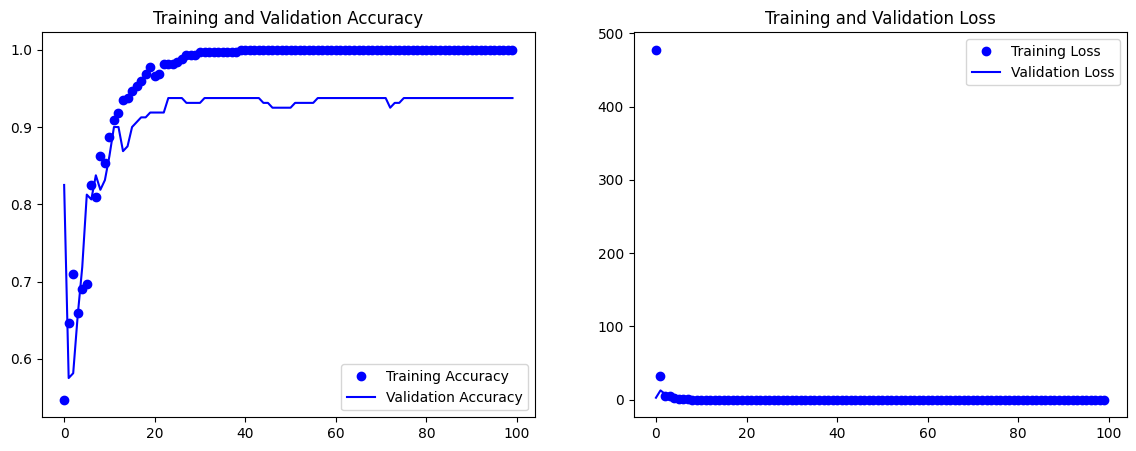

In [ ]:
from matplotlib import pyplot as plt

# Example of encapsulating plotting
def plot_training_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


In [ ]:
label_counts = np.unique(test_generator.classes, return_counts=True)
label_names = [list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(i)] for i in label_counts[0]]
print(dict(zip(label_names, label_counts[1])))

{'LAKI-LAKI': 20, 'PEREMPUAN': 20}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
import tensorflow as tf
import os

# Define a custom object scope that includes the KerasLayer from TensorFlow Hub
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load model with custom object scope
model_path = '/content/drive/My Drive/model_3Juli.h5'

# Verifikasi apakah file model ada
if os.path.exists(model_path):
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = load_model(model_path)
else:
    raise FileNotFoundError(f"No file or directory found at {model_path}")

# Fungsi untuk memproses batch dari generator tes
def process_batches_for_testing(generator, num_batches):
    X_test_images = []
    y_test_labels = []
    for i in range(num_batches):
        X_batch, y_batch = next(generator)
        X_test_images.extend(X_batch)
        y_test_labels.extend(y_batch)
    return np.array(X_test_images), np.array(y_test_labels)

# Mendapatkan batch gambar dan label dari test generator
X_test_images, y_test_labels = process_batches_for_testing(test_generator, num_batches=1)

# Membuat input tambahan dummy (LBP+ASM)
# Misalkan input tambahan yang diharapkan adalah vektor dengan panjang tertentu, misalnya 1288
dummy_length = 1288
X_test_additional = np.zeros((X_test_images.shape[0], dummy_length))

# Memprediksi kelas untuk batch gambar
predictions = model.predict([X_test_images, X_test_additional])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_labels, axis=1)

# Menentukan jumlah gambar yang akan ditampilkan
num_images_to_display = 15
images_per_row = 5
num_rows = num_images_to_display // images_per_row + (1 if num_images_to_display % images_per_row != 0 else 0)

# Plot gambar beserta label asli dan prediksi
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i in range(num_images_to_display):
    ax = axes[i]
    ax.imshow(X_test_images[i])
    true_label = true_classes[i]
    predicted_label = predicted_classes[i]
    ax.set_title(f"True: {true_label}, Pred: {predicted_label}")
    ax.axis('off')

# Menyembunyikan subplot kosong yang tersisa
for i in range(num_images_to_display, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_6" is incompatible with the layer: expected shape=(None, 1186), found shape=(32, 1288)


15/15 [==============================] - 3s 159ms/step
Confusion Matrix:
[[210  23]
 [  9 235]]
Classification Report:
              precision    recall  f1-score   support

   Laki-Laki       0.96      0.90      0.93       233
   Perempuan       0.91      0.96      0.94       244

    accuracy                           0.93       477
   macro avg       0.93      0.93      0.93       477
weighted avg       0.93      0.93      0.93       477



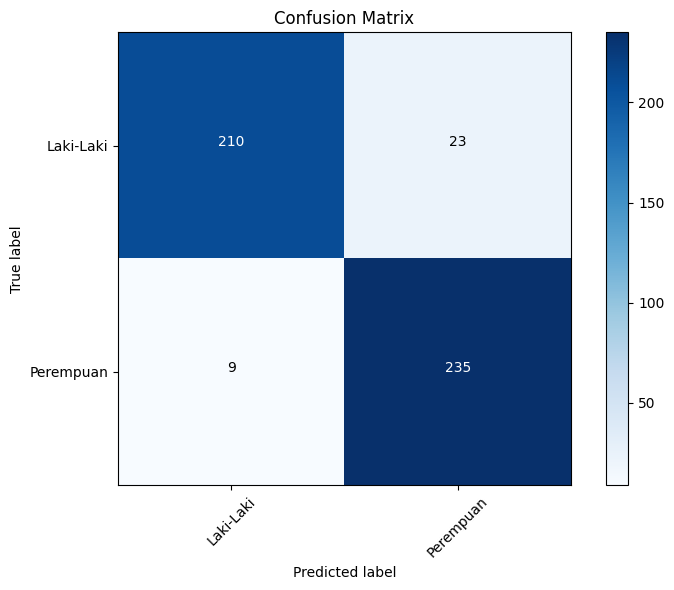

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

# Define a custom object scope that includes the KerasLayer from TensorFlow Hub
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load model with custom object scope
model_path = '/content/drive/My Drive/model_3Juli.h5'
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model(model_path)

# Assuming you have already processed your validation data to get X_val_images and X_val_lbp_asm
# Load or define your validation data here:
X_val_images, X_val_lbp_asm, y_val_labels = process_batches_for_training_parallel(validation_generator, num_batches=len(validation_generator))

# Mengumpulkan prediksi dan label aktual dari data validasi
true_classes = np.argmax(y_val_labels, axis=1)
predicted_classes = np.argmax(model.predict([X_val_images, X_val_lbp_asm]), axis=1)

# Definisikan class_labels
class_labels = ['Laki-Laki', 'Perempuan']

# Buat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Buat classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Tambahkan nilai ke plot
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Define a custom object scope that includes the KerasLayer from TensorFlow Hub
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the model with the custom object scope
model_path = '/content/drive/My Drive/model_1Juli.h5'
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model(model_path)


# Function to preprocess a single image
def preprocess_image(image_path):
    # Load the image
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    # Convert the image to an array
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    # Preprocess the image (normalization, etc.)
    image_array = tf.keras.applications.mobilenet_v3.preprocess_input(image_array)
    # Expand dimensions to match the input shape of the model
    image_array = np.expand_dims(image_array, axis=0)
    return image, image_array

# Function to preprocess additional features (e.g., LBP and ASM)
def preprocess_features():
    # Dummy features for example purposes
    # Replace this with actual feature extraction logic
    additional_features = np.random.rand(1, 554)  # Adjusted to match the expected input shape
    return additional_features

# Path to the test image
test_image_path = '/content/drive/My Drive/Data-test/PEREMPUAN/11S23007_Jelita Sibarani_Pencahayaan Normal.jpg'

# Preprocess the test image
original_image, X_test_image = preprocess_image(test_image_path)

# Preprocess additional features
X_test_features = preprocess_features()

# Make prediction
prediction = model.predict([X_test_image, X_test_features])
predicted_class = np.argmax(prediction, axis=1)

# Define class labels
class_labels = ['Laki-Laki', 'Perempuan']
predicted_label = class_labels[predicted_class[0]]

# Display the image with the predicted label
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


OSError: No file or directory found at /content/drive/My Drive/model_1Juli.h5

1/1 [==============================] - 1s 977ms/step


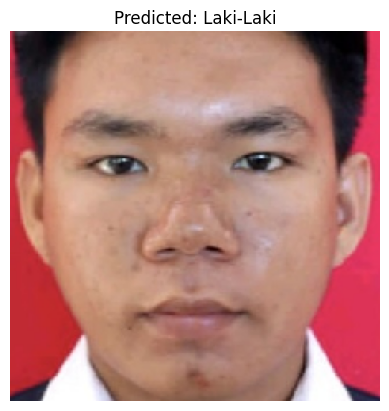

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
import dlib

# Define a custom object scope that includes the KerasLayer from TensorFlow Hub
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the model with the custom object scope
model_path = '/content/drive/My Drive/model_1Juli.h5'
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model(model_path)

# Function to preprocess a single image
def preprocess_image(image_path):
    # Load the image
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    # Convert the image to an array
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    # Preprocess the image (normalization, etc.)
    image_array = tf.keras.applications.mobilenet_v3.preprocess_input(image_array)
    # Expand dimensions to match the input shape of the model
    image_array = np.expand_dims(image_array, axis=0)
    return image, image_array

# Function to extract LBP features
def extract_lbp_features(gray_image, P=8, R=1, grid_size=(7, 7)):
    height, width = gray_image.shape
    grid_h, grid_w = grid_size
    step_h, step_w = height // grid_h, width // grid_w

    lbp_features = []

    for i in range(0, height, step_h):
        for j in range(0, width, step_w):
            grid = gray_image[i:i + step_h, j:j + step_w]
            if grid.shape[0] == 0 or grid.shape[1] == 0:
                continue

            lbp = local_binary_pattern(grid, P, R, method='uniform')
            (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)
            lbp_features.extend(hist)

    return np.array(lbp_features)

# Function to apply ASM and extract features
def apply_asm(gray_image, predictor_path, face_detector):
    gray_image = (gray_image * 224).astype(np.uint8)  # Ensure the image is 8-bit grayscale
    faces = face_detector(gray_image, 1)
    shape_predictor = dlib.shape_predictor(predictor_path)

    if len(faces) == 0:
        return np.zeros(81 * 2)

    for face in faces:
        shape = shape_predictor(gray_image, face)
        coords = np.zeros((81, 2), dtype='int')
        for i in range(0, 81):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        return coords.flatten()

    return np.zeros(81 * 2)

# Function to preprocess additional features (LBP and ASM)
def preprocess_features(image_path, predictor_path, face_detector):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_features = extract_lbp_features(gray_image)
    asm_features = apply_asm(gray_image, predictor_path, face_detector)

    # Ensure the features have the correct shape
    lbp_features = lbp_features[:8 * 7 * 7]  # Adjust the number of LBP features
    asm_features = asm_features[:81 * 2]     # Adjust the number of ASM features

    additional_features = np.concatenate((lbp_features, asm_features), axis=None)
    additional_features = np.expand_dims(additional_features, axis=0)
    return additional_features

# Load the face detector
face_detector = dlib.get_frontal_face_detector()
predictor_path = '/content/drive/My Drive/shape_predictor_81_face_landmarks.dat'  # Update with your actual path

# Path to the test image
test_image_path = '/content/drive/My Drive/Data-test/LAKI-LAKI/13323039_Janter Hugo Purba.jpg'

# Preprocess the test image
original_image, X_test_image = preprocess_image(test_image_path)

# Preprocess additional features
X_test_features = preprocess_features(test_image_path, predictor_path, face_detector)

# Make prediction
prediction = model.predict([X_test_image, X_test_features])
predicted_class = np.argmax(prediction, axis=1)

# Define class labels
class_labels = ['Laki-Laki', 'Perempuan']
predicted_label = class_labels[predicted_class[0]]

# Display the image with the predicted label
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
